<a href="https://colab.research.google.com/github/Aaditya-5281/AI-ML/blob/main/Image_Similarity_using_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an image similarity system with 🤗 Datasets FAISS

In [ ]:
!pip install pyarrow==14.0.1

In [ ]:
!pip install --upgrade cudf-cu12 ibis-framework

  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.1
    Uninstalling pyarrow-14.0.1:
      Successfully uninstalled pyarrow-14.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires ibis-framework[bigquery]<9.0.0dev,>=8.0.0, but you have ibis-framework 9.4.0 which is incompatible.
bigframes 1.15.0 requires sqlglot<=20.11,>=20.8.0, but you have sqlglot 25.18.0 which is incompatible.


In [ ]:
!pip install transformers datasets faiss-cpu -q

## Load model for computing embeddings of the candidate images

In [ ]:
from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load candidate subset

In [ ]:
from datasets import load_dataset


seed = 42
num_samples = 100
dataset = load_dataset("beans", split="train")
candidate_dataset = dataset.shuffle(seed=seed).select(range(num_samples))

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

## Extract embeddings

In [ ]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

In [ ]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})
dataset_with_embeddings.add_faiss_index(column='embeddings')

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['image_file_path', 'image', 'labels', 'embeddings'],
    num_rows: 100
})

## Load test set for querying

In [ ]:
test_ds = load_dataset("beans", split="test")

## Select a random sample and run the query

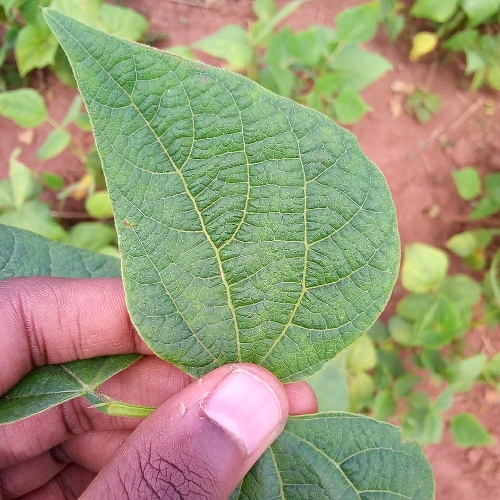

In [20]:
import numpy as np


random_index = np.random.choice(len(test_ds))
query_image = test_ds[random_index]["image"]
query_image

In [21]:
def get_neighbors(query_image, top_k=10):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


scores, retrieved_examples = get_neighbors(query_image)

In [22]:
from PIL import Image


def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Images Similar to the Previous Image

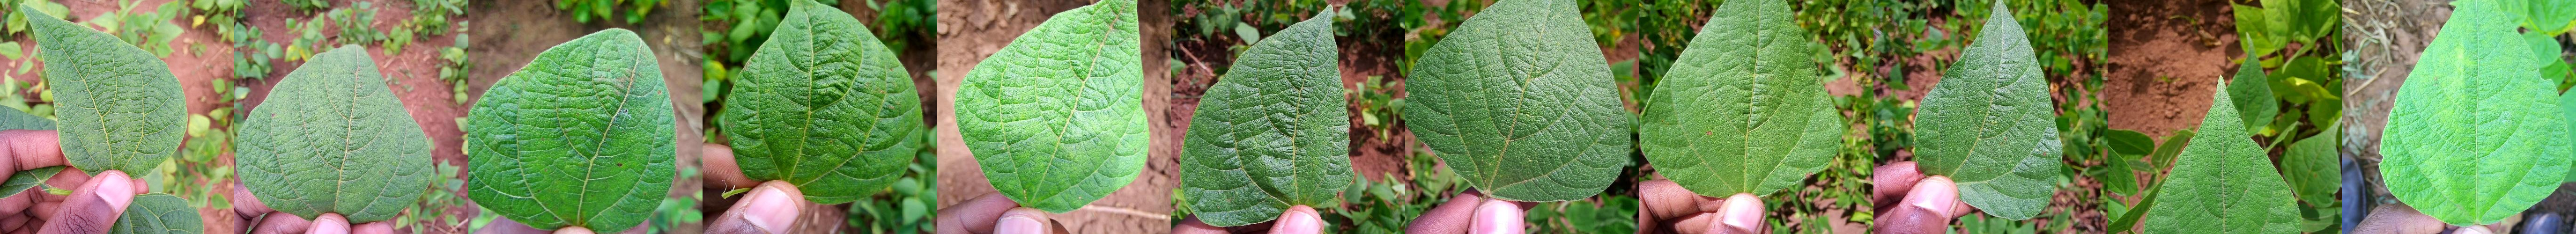

In [23]:
images = [query_image]
images.extend(retrieved_examples["image"])


image_grid(images, 1, len(images))